In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchviz
import matplotlib.pyplot as plt
import networkx as nx

/Users/zave/anaconda3/envs/aiffel-research/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class NeRF(nn.Module):
    def __init__(self, D=8, W=256, input_ch=3, input_ch_views=3, output_ch=4, skips=[4], use_viewdirs=False):
        """ 
        """
        super(NeRF, self).__init__()
        self.D = D
        self.W = W
        self.input_ch = input_ch
        self.input_ch_views = input_ch_views
        self.skips = skips
        self.use_viewdirs = use_viewdirs
        
        self.pts_linears = nn.ModuleList(
            [nn.Linear(input_ch, W)] + [nn.Linear(W, W) if i not in self.skips else nn.Linear(W + input_ch, W) for i in range(D-1)])
        
        ### Implementation according to the official code release (https://github.com/bmild/nerf/blob/master/run_nerf_helpers.py#L104-L105)
        self.views_linears = nn.ModuleList([nn.Linear(input_ch_views + W, W//2)])

        ### Implementation according to the paper
        # self.views_linears = nn.ModuleList(
        #     [nn.Linear(input_ch_views + W, W//2)] + [nn.Linear(W//2, W//2) for i in range(D//2)])
        
        if use_viewdirs:
            self.feature_linear = nn.Linear(W, W)
            self.alpha_linear = nn.Linear(W, 1)
            self.rgb_linear = nn.Linear(W//2, 3)
        else:
            self.output_linear = nn.Linear(W, output_ch)

    def forward(self, x):
        input_pts, input_views = torch.split(x, [self.input_ch, self.input_ch_views], dim=-1)
        h = input_pts
        for i, l in enumerate(self.pts_linears):
            h = self.pts_linears[i](h)
            h = F.relu(h)
            if i in self.skips:
                h = torch.cat([input_pts, h], -1)

        if self.use_viewdirs:
            alpha = self.alpha_linear(h)
            feature = self.feature_linear(h)
            h = torch.cat([feature, input_views], -1)
        
            for i, l in enumerate(self.views_linears):
                h = self.views_linears[i](h)
                h = F.relu(h)

            rgb = self.rgb_linear(h)
            outputs = torch.cat([rgb, alpha], -1)
        else:
            outputs = self.output_linear(h)

        return outputs

Model Architecture:
NeRF(
  (pts_linears): ModuleList(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Linear(in_features=259, out_features=256, bias=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Linear(in_features=256, out_features=256, bias=True)
  )
  (views_linears): ModuleList(
    (0): Linear(in_features=259, out_features=128, bias=True)
  )
  (output_linear): Linear(in_features=256, out_features=4, bias=True)
)

Model Parameters:
Total parameters: 496644

Layer-wise parameter count:
pts_linears.0.weight: 768
pts_linears.0.bias: 256
pts_linears.1.weight: 65536
pts_linears.1.bias: 256
pts_linears.2.weight: 65536
pts_linears.2.bias: 256
pts_linears.3.weight: 65536
pts_linears.3.bias: 256

/var/folders/mw/k_rydbt555l0d4t5g9pbrzrw0000gn/T/ipykernel_71519/3774953948.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Model structure visualization saved as 'nerf_structure.png'


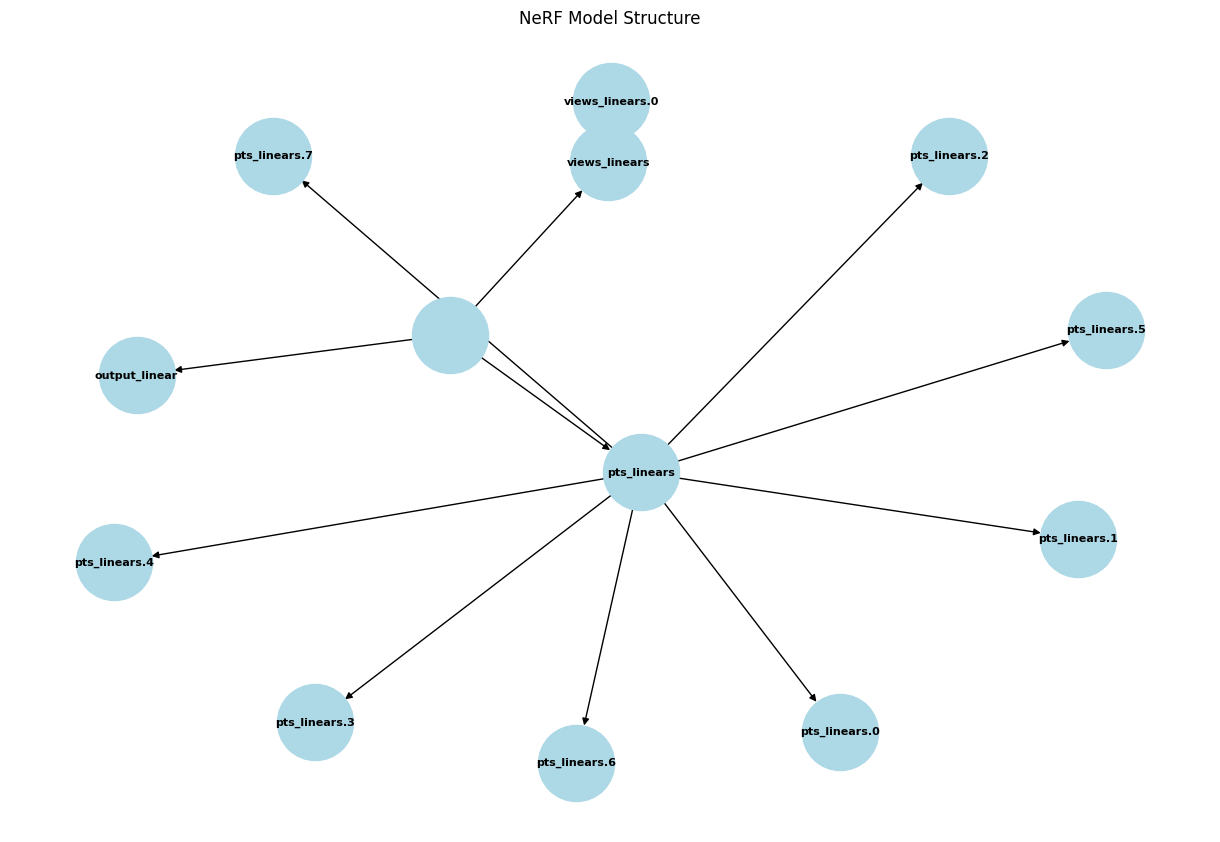

In [3]:
def print_model_info(model):
    print(f"Model Architecture:")
    print(model)
    
    print(f"\nModel Parameters:")
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params}")
    
    print("\nLayer-wise parameter count:")
    for name, param in model.named_parameters():
        print(f"{name}: {param.numel()}")

def visualize_model(model):
    # 더미 입력 생성
    x = torch.randn(1, model.input_ch + model.input_ch_views)
    
    # 계산 그래프 생성
    y = model(x)
    
    # torchviz를 사용하여 그래프 생성
    dot = torchviz.make_dot(y, params=dict(model.named_parameters()))
    
    # PDF로 저장
    dot.render("nerf_model", format="pdf", cleanup=True)
    print("Model visualization saved as 'nerf_model.pdf'")

def visualize_model_structure(model):
    G = nx.DiGraph()
    
    def add_module(module, name=''):
        for child_name, child in module.named_children():
            child_name = f"{name}.{child_name}" if name else child_name
            G.add_edge(name, child_name)
            add_module(child, child_name)
    
    add_module(model)
    
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=3000, font_size=8, font_weight='bold')
    
    plt.title("NeRF Model Structure")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("nerf_structure.png", dpi=300, bbox_inches='tight')
    print("Model structure visualization saved as 'nerf_structure.png'")

# 모델 인스턴스 생성
model = NeRF()

# 모델 정보 출력
print_model_info(model)

# 모델 시각화
visualize_model(model)

# 모델 구조 시각화
visualize_model_structure(model)

Improved model structure visualization saved as 'nerf_structure_improved.png'


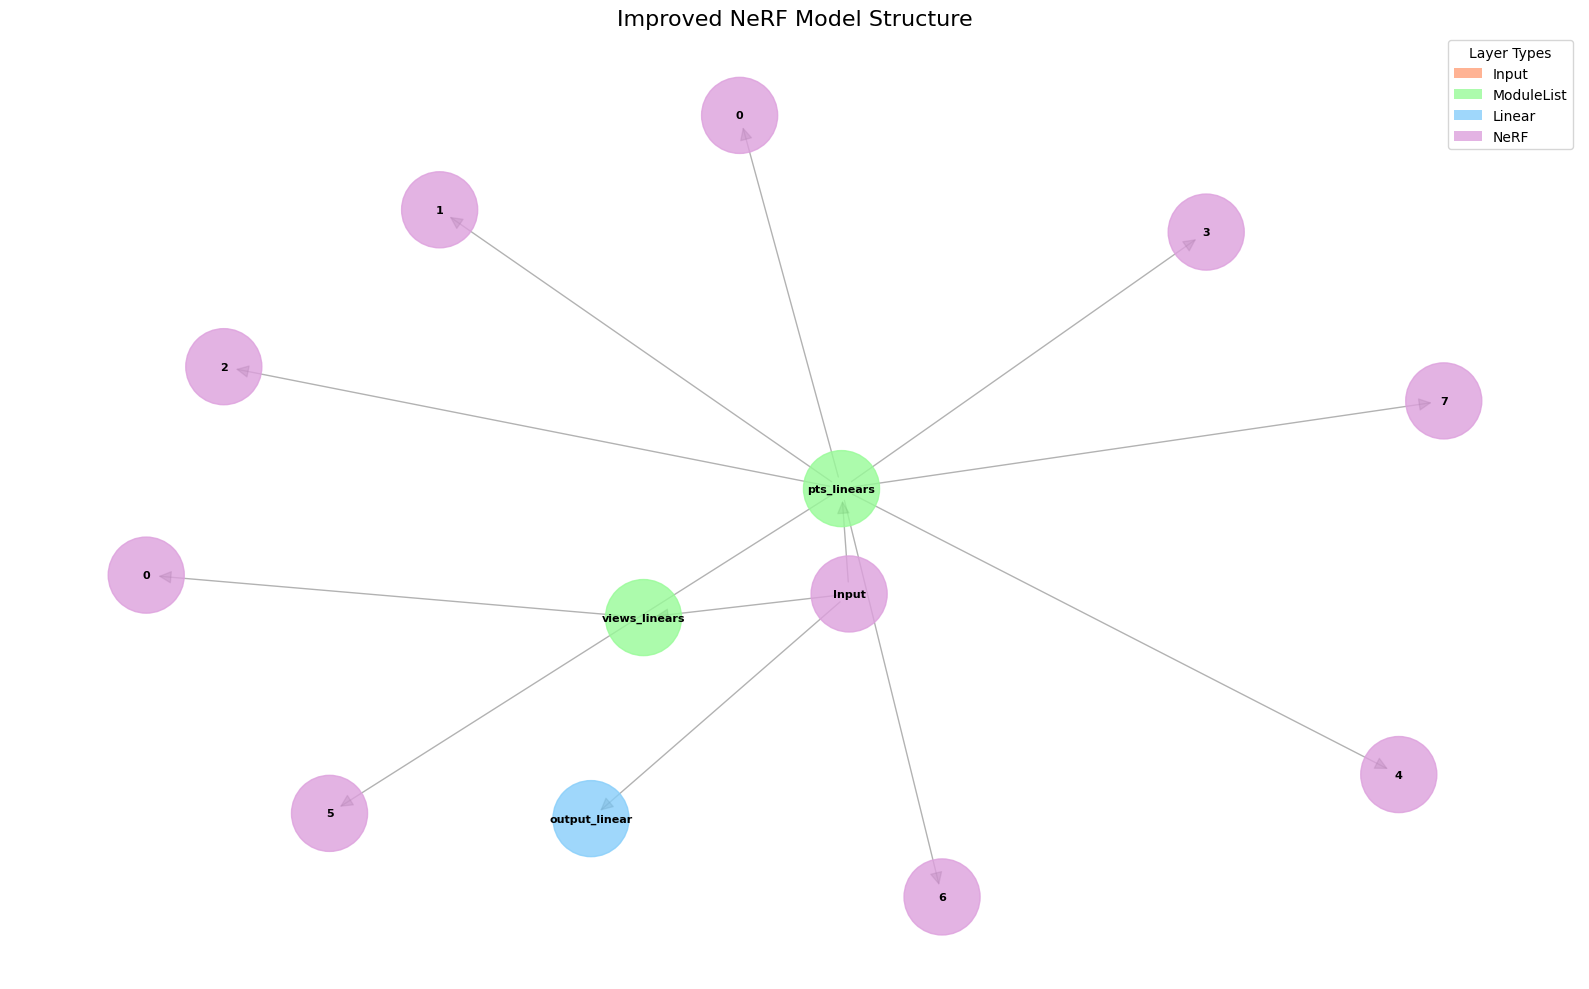

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# (여기에 NeRF 클래스 정의를 넣으세요)

def visualize_model_structure_improved(model):
    G = nx.DiGraph()
    layer_nodes = {}
    
    def add_module(module, name=''):
        if not name:
            name = 'Input'
        if name not in G:
            G.add_node(name)
            layer_type = type(module).__name__
            if layer_type not in layer_nodes:
                layer_nodes[layer_type] = []
            layer_nodes[layer_type].append(name)
        
        for child_name, child in module.named_children():
            child_name = f"{name}.{child_name}" if name != 'Input' else child_name
            G.add_edge(name, child_name)
            add_module(child, child_name)
    
    add_module(model)
    
    plt.figure(figsize=(16, 10))
    pos = nx.spring_layout(G, k=0.9, iterations=50)
    
    # 노드 색상 설정
    color_map = {
        'Input': '#FFA07A',  # Light Salmon
        'ModuleList': '#98FB98',  # Pale Green
        'Linear': '#87CEFA',  # Light Sky Blue
        'NeRF': '#DDA0DD'  # Plum
    }
    
    node_colors = [color_map.get(type(getattr(model, node.split('.')[-1], model)).__name__, '#FFFFFF') for node in G.nodes()]
    
    # 엣지 그리기
    nx.draw_networkx_edges(G, pos, alpha=0.3, arrows=True, arrowsize=20)
    
    # 노드 그리기
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3000, alpha=0.8)
    
    # 레이블 그리기
    labels = {node: node.split('.')[-1] for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold')
    
    # 범례 추가
    legend_elements = [Rectangle((0, 0), 1, 1, fc=color, alpha=0.8, label=layer)
                       for layer, color in color_map.items()]
    plt.legend(handles=legend_elements, loc='upper right', title='Layer Types')
    
    plt.title("Improved NeRF Model Structure", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("nerf_structure_improved.png", dpi=300, bbox_inches='tight')
    print("Improved model structure visualization saved as 'nerf_structure_improved.png'")

# 모델 인스턴스 생성
model = NeRF()

# 개선된 모델 구조 시각화
visualize_model_structure_improved(model)

Enhanced model structure visualization saved as 'nerf_structure_enhanced.png'


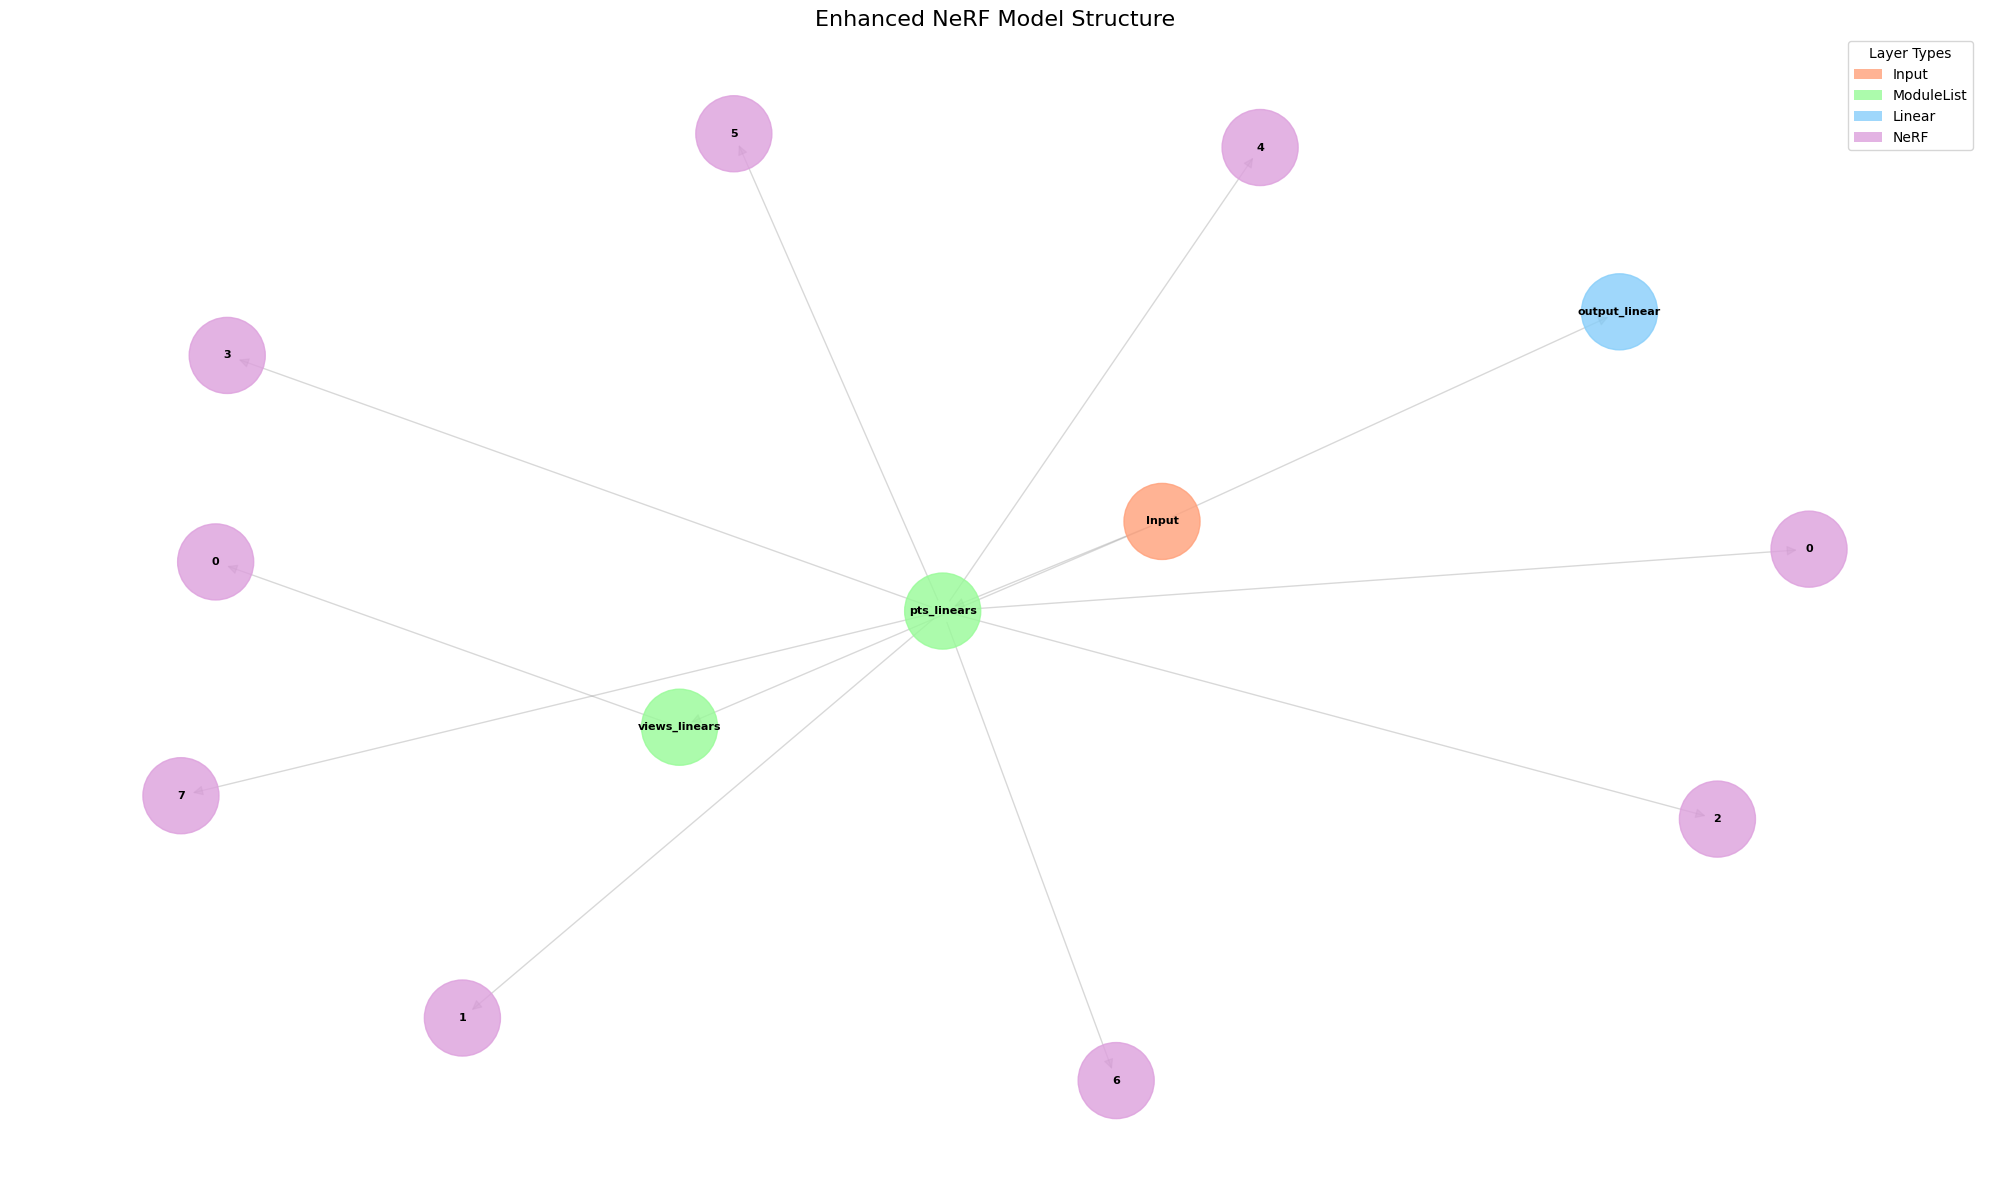

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# (여기에 NeRF 클래스 정의를 넣으세요)

def visualize_model_structure_enhanced(model):
    G = nx.DiGraph()
    layer_nodes = {}
    
    def add_module(module, name=''):
        if not name:
            name = 'Input'
        if name not in G:
            G.add_node(name)
            layer_type = type(module).__name__
            if layer_type not in layer_nodes:
                layer_nodes[layer_type] = []
            layer_nodes[layer_type].append(name)
        
        for child_name, child in module.named_children():
            child_name = f"{name}.{child_name}" if name != 'Input' else child_name
            G.add_edge(name, child_name)
            add_module(child, child_name)
    
    add_module(model)
    
    plt.figure(figsize=(20, 12))
    
    # 계층적 레이아웃 사용
    pos = nx.spring_layout(G, k=0.9, iterations=50)
    
    # 색상 맵 정의
    color_map = {
        'Input': '#FFA07A',  # Light Salmon
        'ModuleList': '#98FB98',  # Pale Green
        'Linear': '#87CEFA',  # Light Sky Blue
        'NeRF': '#DDA0DD'  # Plum
    }
    
    # 노드 색상 설정
    node_colors = []
    for node in G.nodes():
        if node == 'Input':
            node_colors.append(color_map['Input'])
        else:
            node_type = type(getattr(model, node.split('.')[-1], model)).__name__
            node_colors.append(color_map.get(node_type, '#FFFFFF'))
    
    # 엣지 그리기 (노드 뒤에 그려서 가려지지 않도록)
    nx.draw_networkx_edges(G, pos, alpha=0.3, arrows=True, arrowsize=15, edge_color='gray')
    
    # 노드 그리기
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3000, alpha=0.8)
    
    # 레이블 그리기
    labels = {node: node.split('.')[-1] for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold')
    
    # 범례 추가
    legend_elements = [Rectangle((0, 0), 1, 1, fc=color, alpha=0.8, label=layer)
                       for layer, color in color_map.items()]
    plt.legend(handles=legend_elements, loc='upper right', title='Layer Types')
    
    plt.title("Enhanced NeRF Model Structure", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("nerf_structure_enhanced.png", dpi=300, bbox_inches='tight')
    print("Enhanced model structure visualization saved as 'nerf_structure_enhanced.png'")

# 모델 인스턴스 생성
model = NeRF()

# 향상된 모델 구조 시각화
visualize_model_structure_enhanced(model)

NeRF data flow visualization saved as 'nerf_data_flow.png'


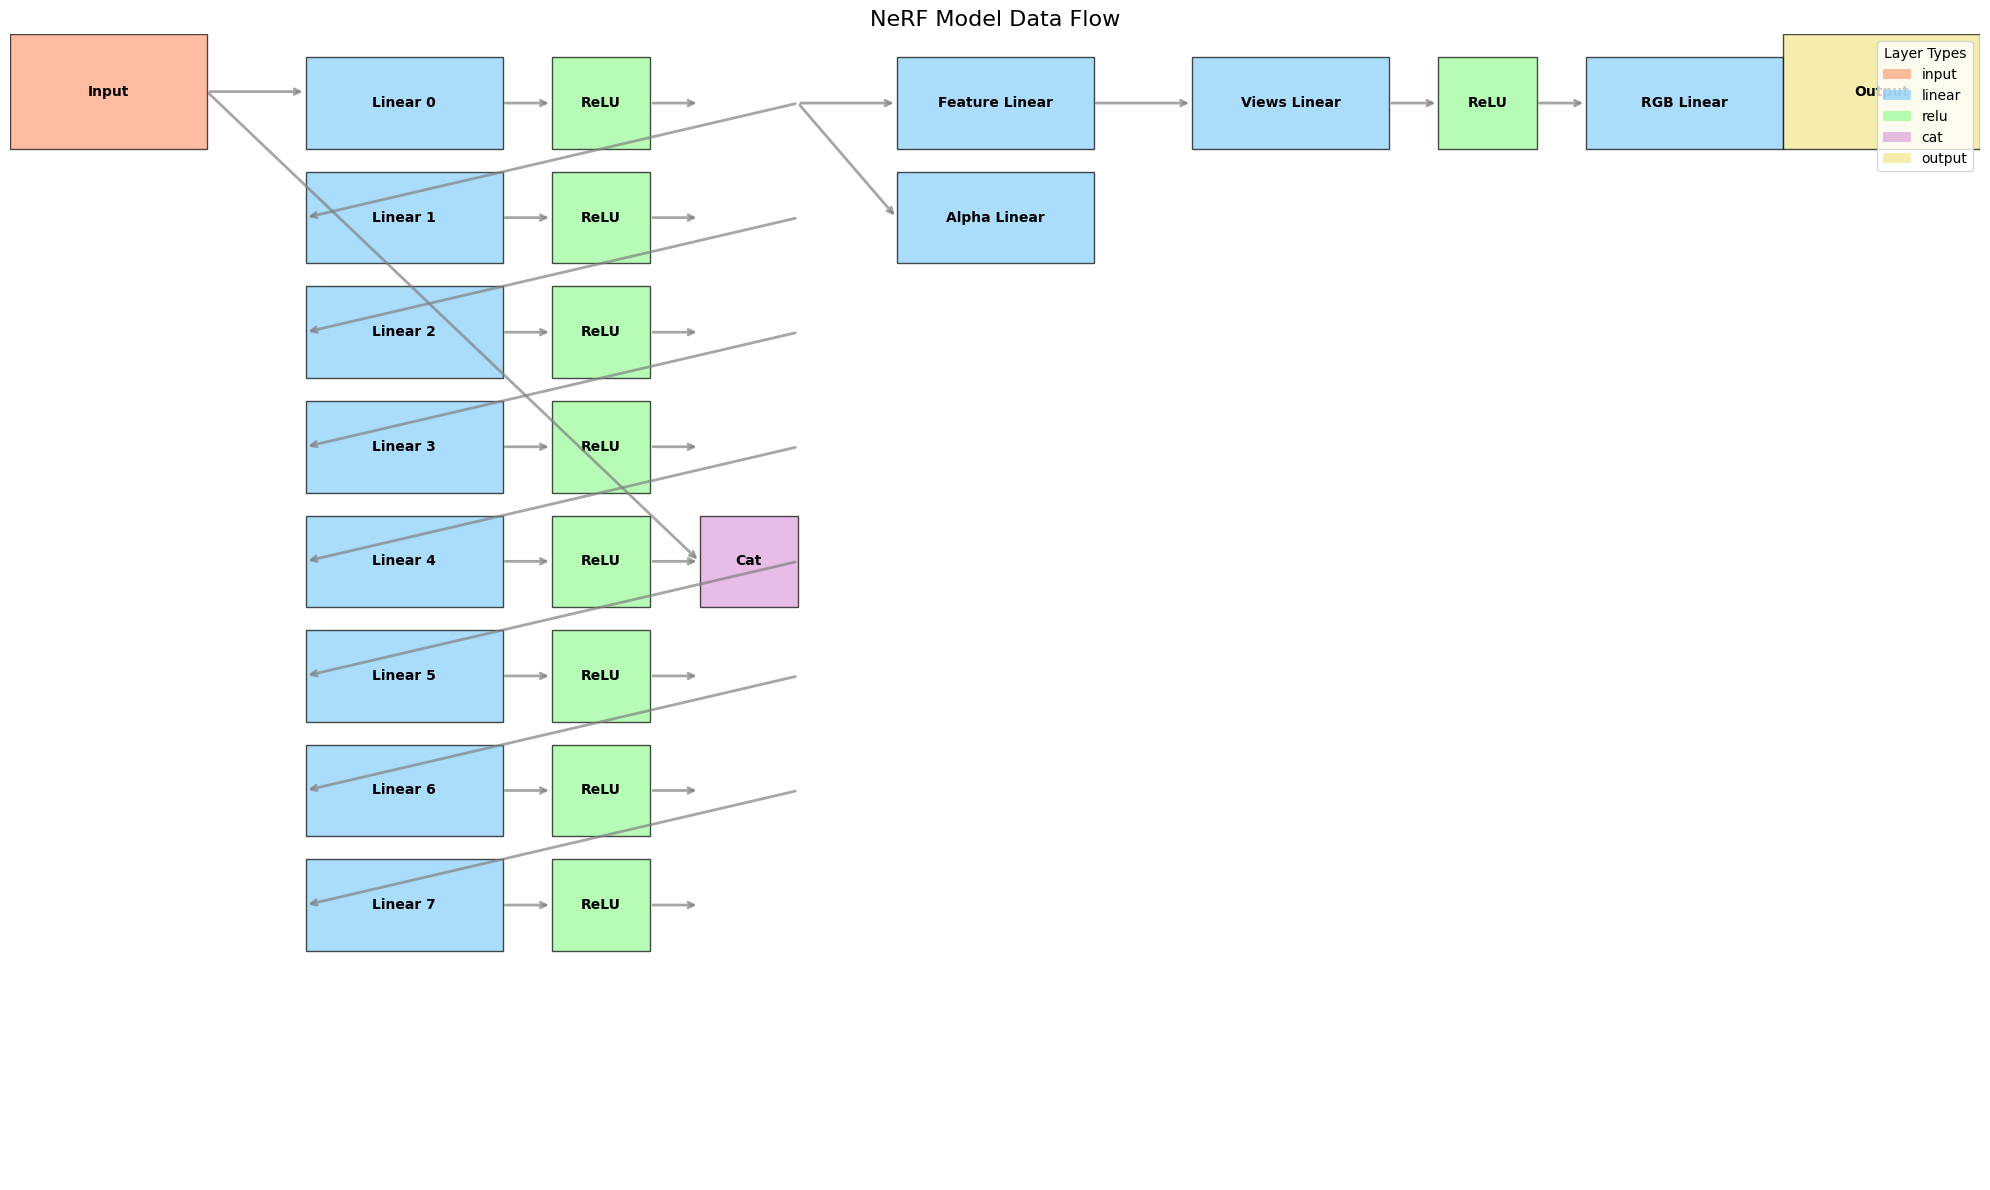

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, ArrowStyle

# (여기에 NeRF 클래스 정의를 넣으세요)

def visualize_nerf_flow(model):
    fig, ax = plt.subplots(figsize=(20, 12))
    
    def add_node(x, y, width, height, name, color):
        rect = Rectangle((x, y), width, height, fill=True, facecolor=color, edgecolor='black', alpha=0.7)
        ax.add_patch(rect)
        ax.text(x + width/2, y + height/2, name, ha='center', va='center', fontweight='bold')
    
    def add_arrow(start, end):
        ax.annotate('', xy=end, xytext=start,
                    arrowprops=dict(arrowstyle='->', lw=2, color='gray', alpha=0.7))
    
    # Define colors
    colors = {
        'input': '#FFA07A',
        'linear': '#87CEFA',
        'relu': '#98FB98',
        'cat': '#DDA0DD',
        'output': '#F0E68C'
    }
    
    # Add input
    add_node(0, 9, 2, 1, 'Input', colors['input'])
    
    # Add pts_linears
    for i in range(model.D):
        add_node(3, 9-i, 2, 0.8, f'Linear {i}', colors['linear'])
        add_node(5.5, 9-i, 1, 0.8, 'ReLU', colors['relu'])
        if i in model.skips:
            add_node(7, 9-i, 1, 0.8, 'Cat', colors['cat'])
    
    # Add feature_linear and alpha_linear
    add_node(9, 9, 2, 0.8, 'Feature Linear', colors['linear'])
    add_node(9, 8, 2, 0.8, 'Alpha Linear', colors['linear'])
    
    # Add views_linears
    add_node(12, 9, 2, 0.8, 'Views Linear', colors['linear'])
    add_node(14.5, 9, 1, 0.8, 'ReLU', colors['relu'])
    
    # Add rgb_linear
    add_node(16, 9, 2, 0.8, 'RGB Linear', colors['linear'])
    
    # Add output
    add_node(18, 9, 2, 1, 'Output', colors['output'])
    
    # Add arrows
    add_arrow((2, 9.5), (3, 9.5))
    for i in range(model.D):
        add_arrow((5, 9.4-i), (5.5, 9.4-i))
        add_arrow((6.5, 9.4-i), (7, 9.4-i))
        if i < model.D - 1:
            add_arrow((8, 9.4-i), (3, 9.4-i-1))
        if i in model.skips:
            add_arrow((2, 9.5), (7, 9.4-i))
    
    add_arrow((8, 9.4), (9, 9.4))
    add_arrow((8, 9.4), (9, 8.4))
    add_arrow((11, 9.4), (12, 9.4))
    add_arrow((14, 9.4), (14.5, 9.4))
    add_arrow((15.5, 9.4), (16, 9.4))
    add_arrow((18, 9.5), (18, 9.5))
    
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 10)
    ax.axis('off')
    plt.title('NeRF Model Data Flow', fontsize=16)
    
    # Add legend
    legend_elements = [Rectangle((0, 0), 1, 1, fc=color, alpha=0.7, label=layer)
                       for layer, color in colors.items()]
    ax.legend(handles=legend_elements, loc='upper right', title='Layer Types')
    
    plt.tight_layout()
    plt.savefig('nerf_data_flow.png', dpi=300, bbox_inches='tight')
    print("NeRF data flow visualization saved as 'nerf_data_flow.png'")

# 모델 인스턴스 생성
model = NeRF()

# NeRF 모델의 데이터 흐름 시각화
visualize_nerf_flow(model)

Improved NeRF data flow visualization saved as 'nerf_data_flow_improved.png'


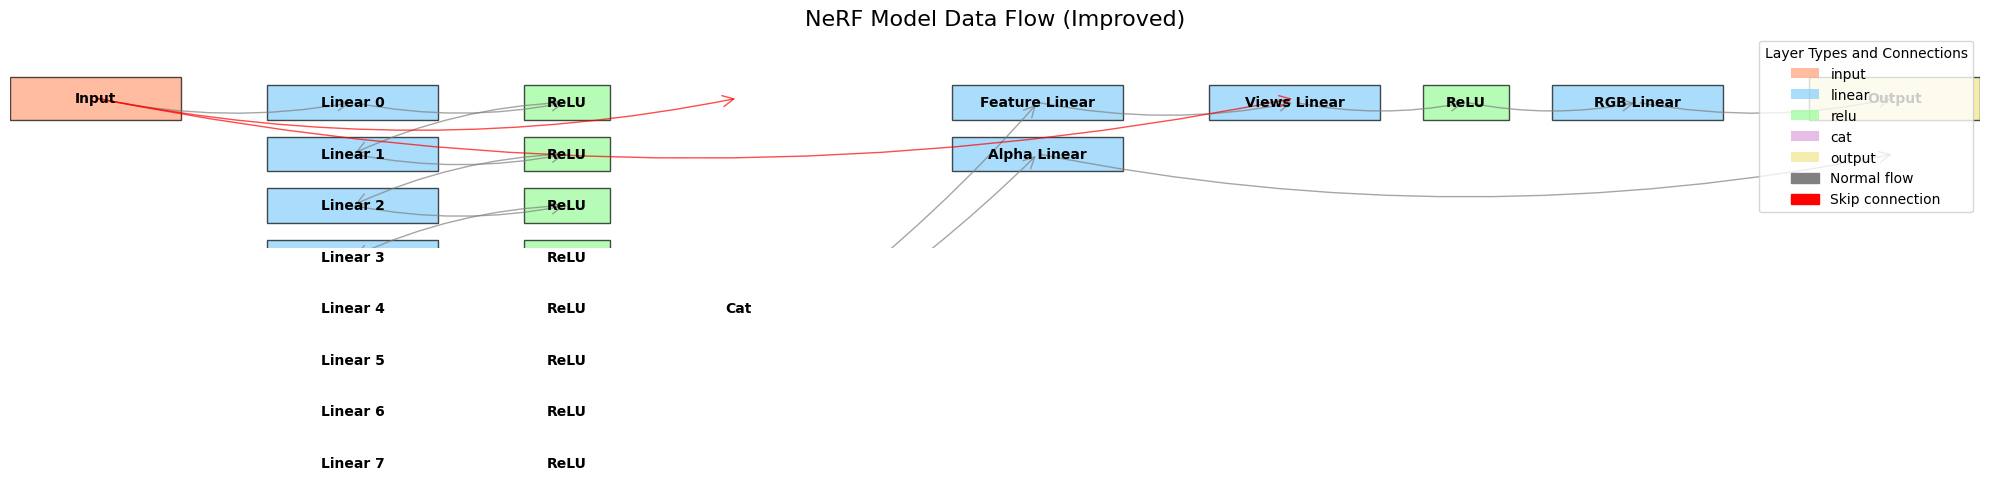

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch

def visualize_nerf_flow_improved(model):
    fig, ax = plt.subplots(figsize=(20, 12))
    
    def add_node(x, y, width, height, name, color):
        rect = Rectangle((x, y), width, height, fill=True, facecolor=color, edgecolor='black', alpha=0.7)
        ax.add_patch(rect)
        ax.text(x + width/2, y + height/2, name, ha='center', va='center', fontweight='bold')
        return x + width/2, y + height/2  # return center coordinates
    
    def add_arrow(start, end, color='gray'):
        arrow = FancyArrowPatch(start, end, arrowstyle='->', color=color, alpha=0.7, 
                                connectionstyle="arc3,rad=0.1", mutation_scale=20)
        ax.add_patch(arrow)
    
    # Define colors
    colors = {
        'input': '#FFA07A',
        'linear': '#87CEFA',
        'relu': '#98FB98',
        'cat': '#DDA0DD',
        'output': '#F0E68C'
    }
    
    # Add input
    input_center = add_node(0, 9, 2, 1, 'Input', colors['input'])
    
    # Add pts_linears
    prev_linear_center = input_center
    for i in range(model.D):
        linear_center = add_node(3, 9-i*1.2, 2, 0.8, f'Linear {i}', colors['linear'])
        relu_center = add_node(6, 9-i*1.2, 1, 0.8, 'ReLU', colors['relu'])
        
        add_arrow(prev_linear_center, linear_center)
        add_arrow(linear_center, relu_center)
        
        if i in model.skips:
            cat_center = add_node(8, 9-i*1.2, 1, 0.8, 'Cat', colors['cat'])
            add_arrow(relu_center, cat_center)
            add_arrow(input_center, (cat_center[0], input_center[1]), 'red')
            prev_linear_center = cat_center
        else:
            prev_linear_center = relu_center
    
    # Add feature_linear and alpha_linear
    feature_linear_center = add_node(11, 9, 2, 0.8, 'Feature Linear', colors['linear'])
    alpha_linear_center = add_node(11, 7.8, 2, 0.8, 'Alpha Linear', colors['linear'])
    
    add_arrow(prev_linear_center, feature_linear_center)
    add_arrow(prev_linear_center, alpha_linear_center)
    
    # Add views_linears
    views_linear_center = add_node(14, 9, 2, 0.8, 'Views Linear', colors['linear'])
    views_relu_center = add_node(16.5, 9, 1, 0.8, 'ReLU', colors['relu'])
    
    add_arrow(feature_linear_center, views_linear_center)
    add_arrow(input_center, (views_linear_center[0], input_center[1]), 'red')
    add_arrow(views_linear_center, views_relu_center)
    
    # Add rgb_linear
    rgb_linear_center = add_node(18, 9, 2, 0.8, 'RGB Linear', colors['linear'])
    add_arrow(views_relu_center, rgb_linear_center)
    
    # Add output
    output_center = add_node(21, 9, 2, 1, 'Output', colors['output'])
    add_arrow(rgb_linear_center, output_center)
    add_arrow(alpha_linear_center, (output_center[0], alpha_linear_center[1]))
    
    ax.set_xlim(0, 23)
    ax.set_ylim(6, 11)
    ax.axis('off')
    plt.title('NeRF Model Data Flow (Improved)', fontsize=16)
    
    # Add legend
    legend_elements = [Rectangle((0, 0), 1, 1, fc=color, alpha=0.7, label=layer)
                       for layer, color in colors.items()]
    legend_elements.append(FancyArrowPatch((0, 0), (1, 0), color='gray', label='Normal flow'))
    legend_elements.append(FancyArrowPatch((0, 0), (1, 0), color='red', label='Skip connection'))
    ax.legend(handles=legend_elements, loc='upper right', title='Layer Types and Connections')
    
    plt.tight_layout()
    plt.savefig('nerf_data_flow_improved.png', dpi=300, bbox_inches='tight')
    print("Improved NeRF data flow visualization saved as 'nerf_data_flow_improved.png'")

# 모델 인스턴스 생성
model = NeRF()

# 개선된 NeRF 모델의 데이터 흐름 시각화
visualize_nerf_flow_improved(model)

In [8]:
import torch
from torchviz import make_dot

# (여기에 NeRF 클래스 정의를 넣으세요)

def visualize_nerf_torchviz(model):
    # 모델 인스턴스 생성
    nerf_model = model()

    # 더미 입력 생성
    x = torch.randn(1, nerf_model.input_ch + nerf_model.input_ch_views)
    
    # 모델 실행
    y = nerf_model(x)
    
    # 계산 그래프 생성 및 시각화
    dot = make_dot(y, params=dict(nerf_model.named_parameters()))
    
    # 그래프 저장
    dot.render("nerf_model_torchviz", format="png", cleanup=True)
    print("NeRF model visualization saved as 'nerf_model_torchviz.png'")

# NeRF 모델 시각화
visualize_nerf_torchviz(NeRF)

NeRF model visualization saved as 'nerf_model_torchviz.png'


/var/folders/mw/k_rydbt555l0d4t5g9pbrzrw0000gn/T/ipykernel_71519/590230331.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


NeRF model visualization saved as 'nerf_model_structure_simple.png'


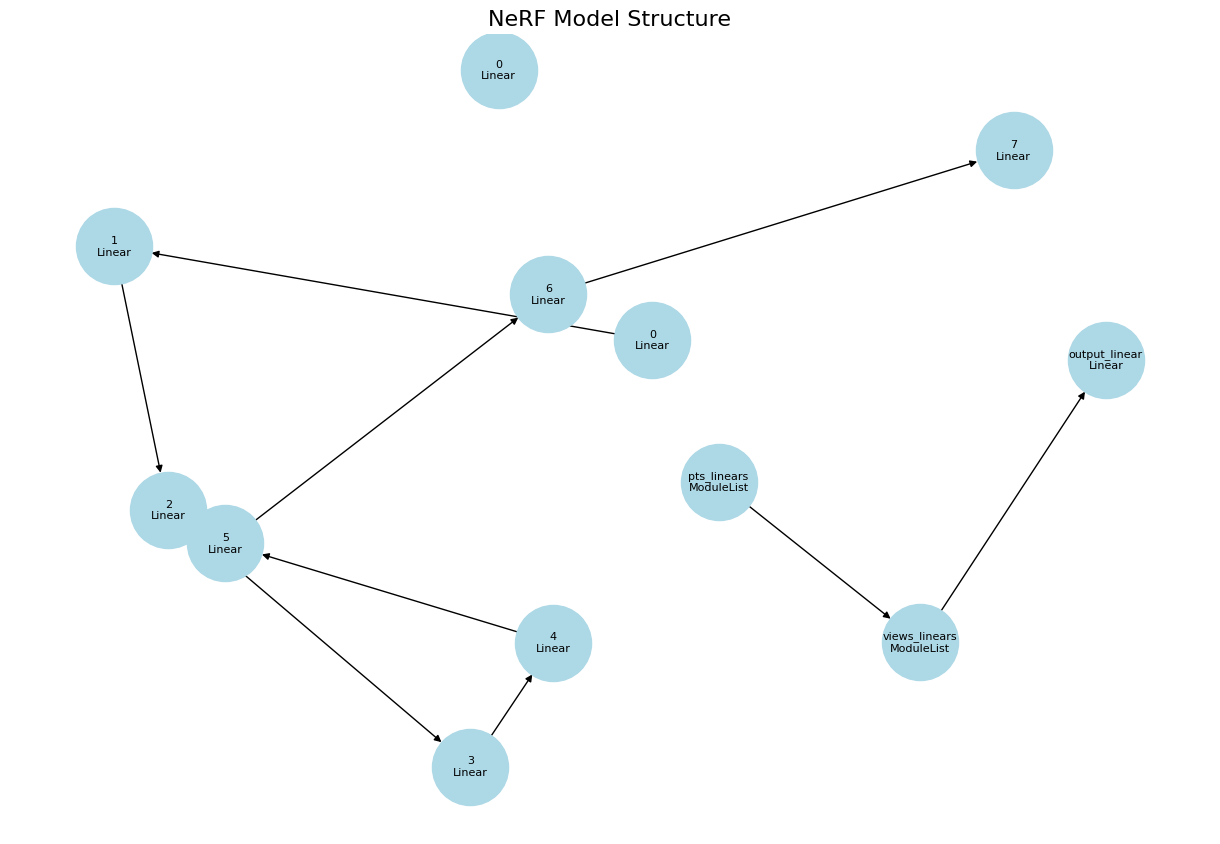

In [9]:
import torch
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt

def visualize_model_structure(model):
    def add_nodes(graph, module, name=''):
        for child_name, child in module.named_children():
            full_name = f"{name}.{child_name}" if name else child_name
            graph.add_node(full_name, label=f"{child_name}\n{type(child).__name__}")
            add_nodes(graph, child, full_name)

    def add_edges(graph, module, name=''):
        children = list(module.named_children())
        for i in range(len(children) - 1):
            current_name = f"{name}.{children[i][0]}" if name else children[i][0]
            next_name = f"{name}.{children[i+1][0]}" if name else children[i+1][0]
            graph.add_edge(current_name, next_name)
        
        for child_name, child in module.named_children():
            full_name = f"{name}.{child_name}" if name else child_name
            add_edges(graph, child, full_name)

    G = nx.DiGraph()
    add_nodes(G, model)
    add_edges(G, model)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=1, iterations=50)
    nx.draw(G, pos, with_labels=False, node_size=3000, node_color='lightblue', 
            font_size=10, font_weight='bold', arrows=True)
    
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels, font_size=8)

    plt.title("NeRF Model Structure", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("nerf_model_structure_simple.png", format="png", dpi=300, bbox_inches='tight')
    print("NeRF model visualization saved as 'nerf_model_structure_simple.png'")

# NeRF 모델 인스턴스 생성
model = NeRF()

# 모델 구조 시각화
visualize_model_structure(model)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot

# 모델 인스턴스화
model = NeRF(D=8, W=256, input_ch=3, input_ch_views=3, output_ch=4, skips=[4], use_viewdirs=True)

# 더미 입력 생성
dummy_input = torch.randn(1, 6)  # (batch_size, input_ch + input_ch_views)

# 모델에 더미 입력을 통과시켜 출력 얻기
output = model(dummy_input)

# torchviz를 사용하여 계산 그래프 생성
dot = make_dot(output, params=dict(model.named_parameters()))

# 그래프를 SVG 파일로 저장
dot.render("nerf_model_graph", format="svg", cleanup=True)

print("NeRF 모델 그래프가 'nerf_model_graph.svg' 파일로 저장되었습니다.")

NeRF 모델 그래프가 'nerf_model_graph.svg' 파일로 저장되었습니다.


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot

class SimplifiedNeRF(nn.Module):
    def __init__(self, D=8, W=256, input_ch=3, input_ch_views=3, output_ch=4):
        super(SimplifiedNeRF, self).__init__()
        self.input_layer = nn.Linear(input_ch, W)
        self.middle_layer = nn.Linear(W, W)
        self.view_layer = nn.Linear(input_ch_views + W, W//2)
        self.feature_layer = nn.Linear(W, W)
        self.alpha_layer = nn.Linear(W, 1)
        self.rgb_layer = nn.Linear(W//2, 3)

    def forward(self, x):
        input_pts, input_views = torch.split(x, [3, 3], dim=-1)
        
        h = F.relu(self.input_layer(input_pts))
        h = F.relu(self.middle_layer(h))
        
        alpha = self.alpha_layer(h)
        feature = self.feature_layer(h)
        
        h = torch.cat([feature, input_views], -1)
        h = F.relu(self.view_layer(h))
        
        rgb = self.rgb_layer(h)
        outputs = torch.cat([rgb, alpha], -1)
        
        return outputs

# 모델 인스턴스화
model = SimplifiedNeRF()

# 더미 입력 생성
dummy_input = torch.randn(1, 6)  # (batch_size, input_ch + input_ch_views)

# 모델에 더미 입력을 통과시켜 출력 얻기
output = model(dummy_input)

# torchviz를 사용하여 계산 그래프 생성
dot = make_dot(output, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

# 그래프를 SVG 파일로 저장
dot.render("simplified_nerf_model_graph", format="svg", cleanup=True)

print("간소화된 NeRF 모델 그래프가 'simplified_nerf_model_graph.svg' 파일로 저장되었습니다.")

간소화된 NeRF 모델 그래프가 'simplified_nerf_model_graph.svg' 파일로 저장되었습니다.
